Comme tâche exemple, on veut générer des digits manuscrits, à partir d'un nombre.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)


In [5]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [6]:
# Point to training loop video
num_epochs = 5
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))



/home/hippo/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch:1, Loss:0.0096
Epoch:2, Loss:0.0060
Epoch:3, Loss:0.0044
Epoch:4, Loss:0.0037
Epoch:5, Loss:0.0032


In [9]:
#sauvegarde du modèle
torch.save(model.state_dict(), '../model/firstVAE.pth')

In [ ]:
print(type(outputs))
print(len(outputs))
print(type(outputs[0]))
print(len(outputs[0]))
print(type(outputs[0][0]))
print(type(outputs[0][1]))
print(type(outputs[0][2]))
print(outputs[0][0])
print(outputs[0][1].shape)
print(outputs[0][2].shape)
print(outputs[0][1][0]) #affichage de la première image du batch
print(outputs[0][2][0]) #affichage de la première image reconstruite du batch



In [ ]:
#for k in range(0, num_epochs, 4):
for k in [0, 1, 2, 3, 4]:
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        plt.imshow(item[0])



## Il faut pouvoir analyser l'espace latent du VAE... 
C'est ce LS qu'on va vouloir utiliser ensuite 

## Test de réduction de la taille de l'espace latent

In [6]:
class Autoencoder2(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), # -> N, 64, 1, 1
            #on réduit encore la taille du LS
            nn.ReLU(),
            nn.Conv2d(64, 16, 1) # -> N, 16, 1, 1
   
        )
        
        # N , 16, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 64, 1), # -> N, 64, 1, 1
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

...Même chose mais plutot que de copier le code on modifie seulement une partie d'un modèle préexistant

In [26]:
model2 = Autoencoder2()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)


# Point to training loop video
num_epochs = 5
outputs = []
#on peut rajouter une ligne à l'outputs avant l'entrainement
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model2(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0373
Epoch:2, Loss:0.0158
Epoch:3, Loss:0.0143
Epoch:4, Loss:0.0142
Epoch:5, Loss:0.0099


In [29]:
#sauvegarde du modèle
torch.save(model2.state_dict(), '../model/secondVAE.pth')

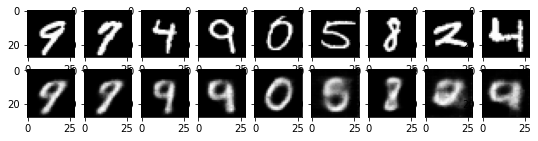

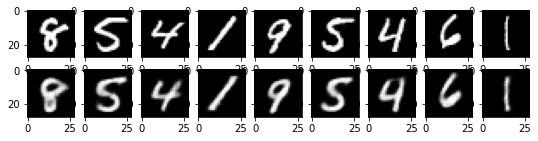

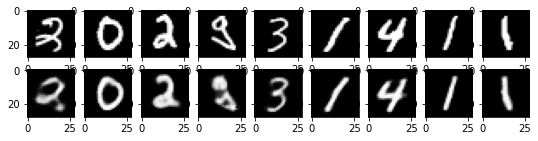

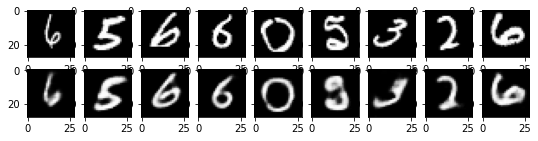

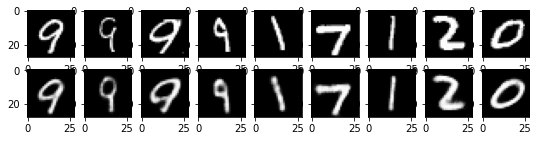

In [27]:
#for k in range(0, num_epochs, 4):
for k in [0, 1, 2, 3, 4]:
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        plt.imshow(item[0])

... on refait la même chose avec un autoencoder dont le LS est encore plus petit

In [7]:
class Autoencoder3(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), # -> N, 64, 1, 1
            #on réduit encore la taille du LS
            nn.ReLU(),
            nn.Conv2d(64, 32, 1), # -> N, 16, 1, 1
            nn.ReLU(),
            nn.Conv2d(32, 2, 1) # -> N, 8, 1, 1
   
        )
        
        # N , 2, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 32, 1), # -> N, 16, 1, 1
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 1), # -> N, 64, 1, 1
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [44]:
model3 = Autoencoder3()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)


# Point to training loop video
num_epochs = 5
outputs = []
#on peut rajouter une ligne à l'outputs avant l'entrainement
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model3(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0496
Epoch:2, Loss:0.0433
Epoch:3, Loss:0.0410
Epoch:4, Loss:0.0415
Epoch:5, Loss:0.0380


In [47]:
#sauvegarde du modèle
torch.save(model3.state_dict(), '../model/thirdVAE.pth')

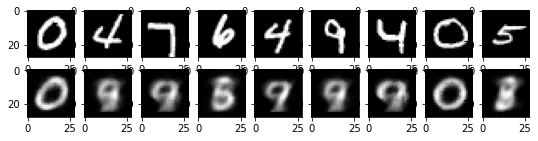

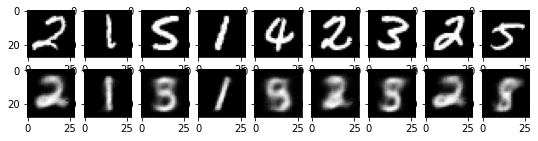

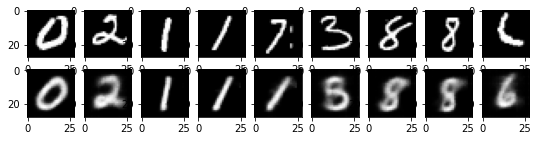

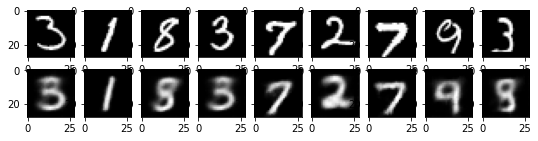

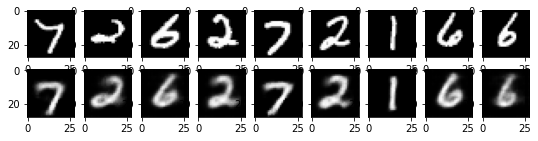

In [48]:
#for k in range(0, num_epochs, 4):
for k in [0, 1, 2, 3, 4]:
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        plt.imshow(item[0])

... on peut construire plutot un AE dont l'architecture est paramétrisable 

In [8]:
class AE(nn.Module):
    def __init__(self,dimLS):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), # -> N, 64, 1, 1
            #on réduit encore la taille du LS
            nn.ReLU(),
            nn.Conv2d(64, 32, 1), # -> N, 32, 1, 1
            nn.ReLU(),
            nn.Conv2d(32, dimLS, 1) # -> N, dimLS, 1, 1
   
        )
        
        # N , 2, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(dimLS, 32, 1), # -> N, 32, 1, 1
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 1), # -> N, 64, 1, 1
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self,x):
        return self.encoder(x)
    
    def generate(self,x):
        return self.decoder(x)
        

## Travail sur la loss 

## Generation de digit à partir de l'espace latent

L'ecriture du AE de départ ne permet pas de récupérer le decodeur pour génération si ? 
* il faut un "partial forward pass"... pour laisser le réseau faire une partie des calculs seulement en eval 


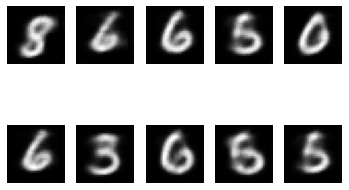

In [48]:
#recuperer les poids du model 
#weights = model.state_dict()
#pas oublier la différence entre parameters et state_dict 
#params = model.parameters() 

Tmodel = AE(2)
# on charge les poids des modèles appris
Tmodel.load_state_dict(torch.load('../model/thirdVAE.pth'))
#on passe le modèle en mode evaluation
Tmodel.eval()
# on genere des digits manuscrits depuis le LS
#on génère un LS 
latent_space = torch.randn(10, 2, 1, 1)
digits = Tmodel.generate(latent_space)
#on affiche les digits générés
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(digits[i][0].detach().numpy(), cmap='gray')
    plt.axis('off')


...on genere selon une ou l'autre dimension pour voir la différence

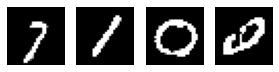

In [49]:
#on crée un tenseur de taille 10,2,1,1 avec des 0 ou des 1
#latent_space = torch.tensor([[[0],[0]],[[0],[0]],[[0],[0]],[[0],[0]]])
latent_space = torch.tensor([[[[-1000]],[[-1000]]],[[[-1000]],[[1000]]],[[[1000]],[[-1000]]],[[[1000]],[[1000]]]], dtype=torch.float32)
#latent_space =torch.randn(10, 2, 1, 1)
latent_space.shape

digits = Tmodel.generate(latent_space)

#on affiche les digits générés
for i in range(4):
    plt.subplot(2, 5, i+1)
    plt.imshow(digits[i][0].detach().numpy(), cmap='gray')
    plt.axis('off')



* Reflexion sur les propriétés de l'espace latent obtenu :
  <br/>
  <br/>
  - des objets proches dans l'espace latent doivent être sémantiquement proche dans l'espace du stimuli (RSA, comparaison de RDM)
  - est-ce que tout le manifold a bien été capturé dans le LS(= toutes les manières d'écrire les nombres peuvent être générée ?)
  - est-ce que le LS ne contient "que' le manifold ? (= à partir de n'importe quel point de l'espace latent on obtient une image vraisemblabl ) --> est-ce qu'on veut toujours ça ? justement non, il faut être capable de faire de l'interpolation ?
  - répartition "unimodale" des classes 
  - qu'est-ce qu'on bon nombre de dimension en fonction de ce que l'on veut
  - ???
  


## Visualisation des objets dans l'espace latent

In [7]:
# on calcule les coordonnées des objets dans le LS
#on récupère les données
Tmodel.eval()
coord = []
labels = []
for imgs, lbls in data_loader:
    #on encode les images
    latent_space = Tmodel.encode(imgs)
    #latent_space = latent_space.squeeze()
    #on récupère les coordonnées du LS
    latent_space = latent_space.detach().numpy()
    #on récupère les labels
    lbls = lbls.numpy()

    #on veut une liste de coordonnées associées à un label
    for i in range(len(latent_space)):
        coord.append(latent_space[i])
        labels.append(lbls[i])

for co in coord:
    co = co.reshape(2)

    
# #on fait une ACP pour visualiser les données
# pca = PCA(n_components=2)
# pca.fit(latent_space)
# latent_space = pca.transform(latent_space)

# #on affiche les données
# plt.scatter(latent_space[:,0], latent_space[:,1], c=labels, cmap='tab10')
# plt.colorbar()



NameError: name 'Tmodel' is not defined

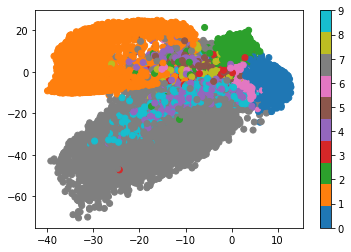

In [74]:
#on affiche les coordonnées
plt.scatter([co[0] for co in coord], [co[1] for co in coord], c=labels, cmap='tab10')
#on affiche les labels qui correspondent aux couleurs 
plt.colorbar()


## Passage au VAE

1. Definition du VAE

In [38]:
class VAE(nn.Module):
    def __init__(self,dimLS = 2):
        super().__init__()        
        # N, 1, 28, 28

        '''
        bien avoir en tête qu'à chaque fois on ne fait que définir 
        une succession d'opérations paramétrisables
        '''
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), # -> N, 64, 1, 1
            #on réduit encore la taille du LS
            nn.ReLU(),
            nn.Conv2d(64, 32, 1), # -> N, 32, 1, 1
            nn.ReLU(),
            nn.Conv2d(32, dimLS, 1) # -> N, dimLS, 1, 1
            
        )
        
        #on pourrait directement faire le flatten et le view ici !

        '''
        Est-ce qu'on doit définir un bottleneck ici ? 
        <=> il y a une opération qui se fait entre le LS de l'encoder et mu/sigma ?
        '''
        self.fc_mu = nn.Linear(dimLS, dimLS) # -> N, dimLS, 1, 1  on veut ça aussi ! 
        self.fc_var = nn.Linear(dimLS, dimLS)
        #on applique la fonction identité (test)
        # self.fc_mu = nn.Identity()
        # self.fc_var = nn.Identity()

        
        # N , 2, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(dimLS, 32, 1), # -> N, 32, 1, 1
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 1), # -> N, 64, 1, 1
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )
####
    '''
    on doit inclure dans le forward la fonction de reparamétrisation
    qui renvoie un LS samplé à partir de la moyenne et de la variance
    '''
    def forward(self, x):
####  
        '''si mu et sigma n'etait pas définit par un self quelque part,
        il ne pourrait pas avoir de poids associés aux opérations...
        '''
        mu, logvar = self.encode(x) #on utilise la fonction encode et pas directement l'encoder !
        #print(mu.shape)
        z = self.reparametrize(mu, logvar)
        #print(z.shape)
        decoded = self.decode(z)
        #print('bbbb')
        return decoded
    
    def encode(self,x):
        result = self.encoder(x) 
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return [mu, log_var]
    
    def decode(self,z):
        z_reshaped = z.view(-1, 2, 1, 1)
        decoded = self.decoder(z_reshaped)
        return decoded
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    #on peut aussi écrire une fonction pour regarder la différence entre les images dans le LS avant et après le sampling
        

2. Entrainement du modèle

In [39]:
Vmodel = VAE()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Vmodel.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)


# Point to training loop video
num_epochs = 5
outputs = []
#on peut rajouter une ligne à l'outputs avant l'entrainement
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = Vmodel(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

torch.Size([64, 2, 1, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x1 and 2x2)